In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
#importing Libraries 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow 
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
tf.keras.backend.clear_session()
from sklearn.metrics import plot_confusion_matrix
from sklearn import datasets, tree, linear_model, svm
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eeg-brainwave-dataset-feeling-emotions/emotions.csv


In [2]:
'''This is a dataset of EEG brainwave data that has been processed with original strategy of statistical extraction 
    the data set consist brain signal of one male and one feamle by showing them different scenes (like Emotional,Funny,Death,Nature scenes) 
    and took their brain signal in these particular environments'''

#Reading dataset
data = pd.read_csv("../input/eeg-brainwave-dataset-feeling-emotions/emotions.csv")

In [3]:
#chceking length of dataset
len(data)

2132

In [4]:
from pykalman import KalmanFilter

# Selecting a subset of features for demonstration (e.g., the first 10 features)
selected_features = data.columns[:10]

# Applying Kalman Filter and Smoothing to the selected features
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
filtered_and_smoothed_data = data.copy()

for feature in selected_features:
    measurements = data[feature].values
    kf = kf.em(measurements, n_iter=10)
    (filtered_state_means, _) = kf.filter(measurements)
    (smoothed_state_means, _) = kf.smooth(measurements)
    filtered_and_smoothed_data[feature] = smoothed_state_means.squeeze()

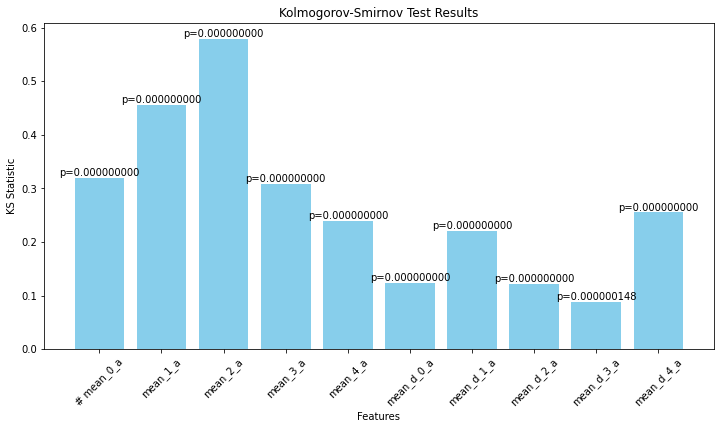

In [5]:
from scipy.stats import ks_2samp

# Function for Kolmogorov-Smirnov Test
def perform_ks_test(original_data, modified_data, features):
    ks_results = {}
    for feature in features:
        ks_stat, ks_p_value = ks_2samp(original_data[feature], modified_data[feature])
        ks_results[feature] = {'KS Statistic': ks_stat, 'P-Value': ks_p_value}
    return ks_results

# ... [Your existing code for loading data and applying Kalman Filter and Smoothing] ...

# Selected features for KS Test
selected_features = data.columns[:10]  # Adjust as per your requirement

# Perform the KS Test
ks_test_results = perform_ks_test(data, filtered_and_smoothed_data, selected_features)

# Now you can analyze the ks_test_results


import matplotlib.pyplot as plt

def plot_ks_results(ks_results):
    # Extracting KS statistics and feature names
    ks_statistics = [ks_results[feature]['KS Statistic'] for feature in ks_results]
    p_values = [ks_results[feature]['P-Value'] for feature in ks_results]
    features = list(ks_results.keys())

    # Creating a bar plot for KS statistics
    plt.figure(figsize=(12, 6))
    plt.bar(features, ks_statistics, color='skyblue')
    
    # Adding p-values as text annotations
    for i, p in enumerate(p_values):
        plt.text(i, ks_statistics[i], f'p={p:.9f}', ha='center', va='bottom')

    plt.xlabel('Features')
    plt.ylabel('KS Statistic')
    plt.title('Kolmogorov-Smirnov Test Results')
    plt.xticks(rotation=45)
    plt.show()

# ... [Your existing code] ...

# After performing the KS test
plot_ks_results(ks_test_results)


In [6]:
#len(filtered_and_smoothed_data)
data = filtered_and_smoothed_data

In [7]:
#Seprarting Positive,Neagtive and Neutral dataframes for plortting
pos = data.loc[data["label"]=="POSITIVE"]
sample_pos = pos.loc[2, 'fft_0_b':'fft_749_b']
neg = data.loc[data["label"]=="NEGATIVE"]
sample_neg = neg.loc[0, 'fft_0_b':'fft_749_b']
neu = data.loc[data["label"]=="NEUTRAL"]
sample_neu = neu.loc[1, 'fft_0_b':'fft_749_b']

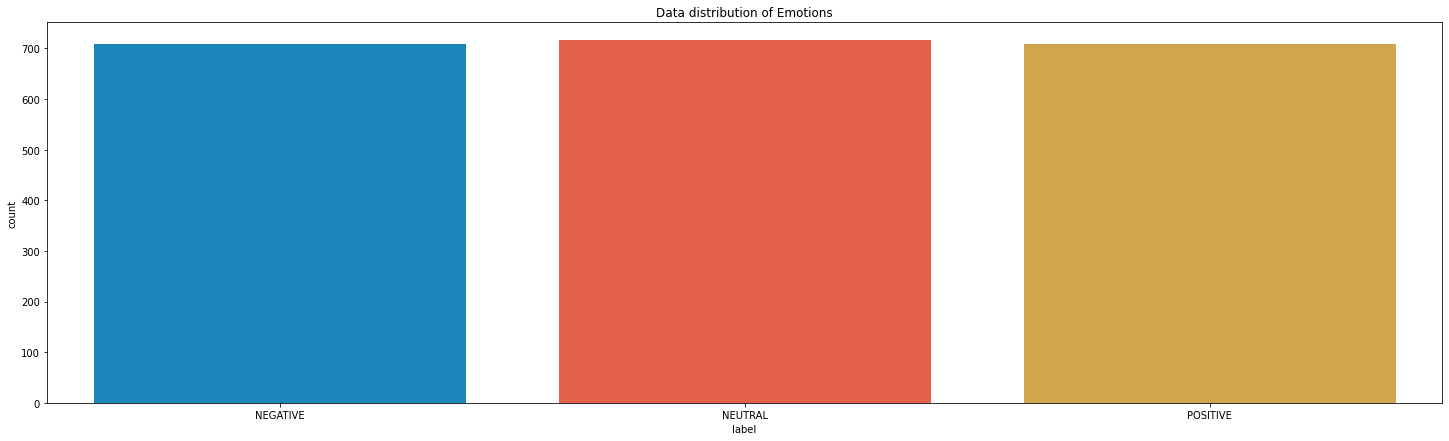

In [8]:
#plottintg Dataframe distribution
plt.figure(figsize=(25,7))
plt.title("Data distribution of Emotions")
plt.style.use('fivethirtyeight')
sns.countplot(x='label', data=data)
plt.show()

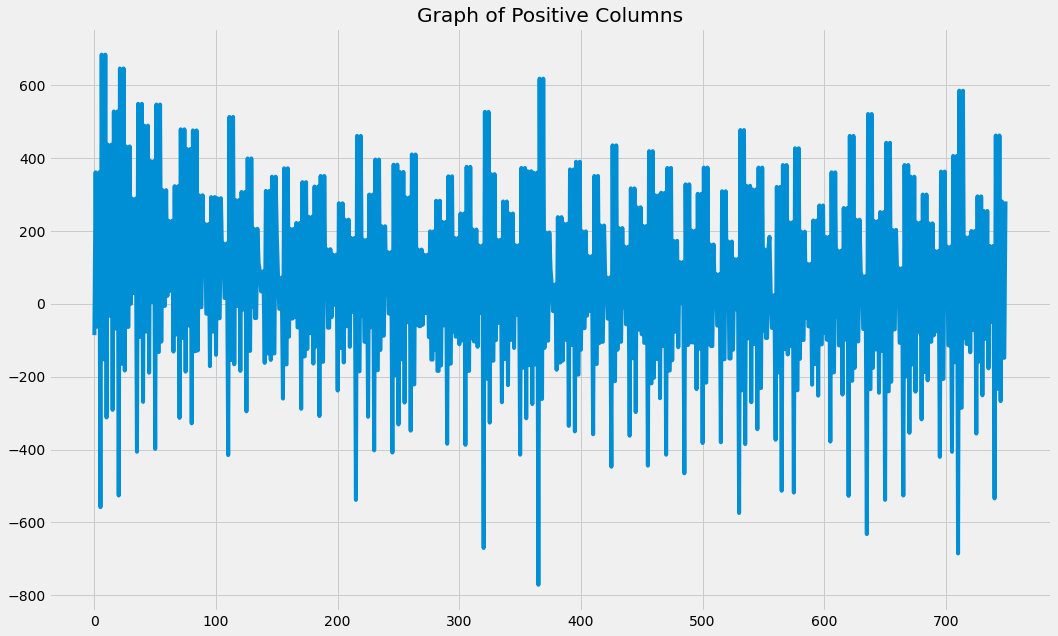

'As we can noticed the most of the Negative Signals are from greater than 600 to and less than than -600'

In [9]:
#Plotting Positive DataFrame
plt.figure(figsize=(16, 10))
plt.plot(range(len(sample_pos)), sample_pos)
plt.title("Graph of Positive Columns")
plt.show()
'''As we can noticed the most of the Negative Signals are from greater than 600 to and less than than -600'''

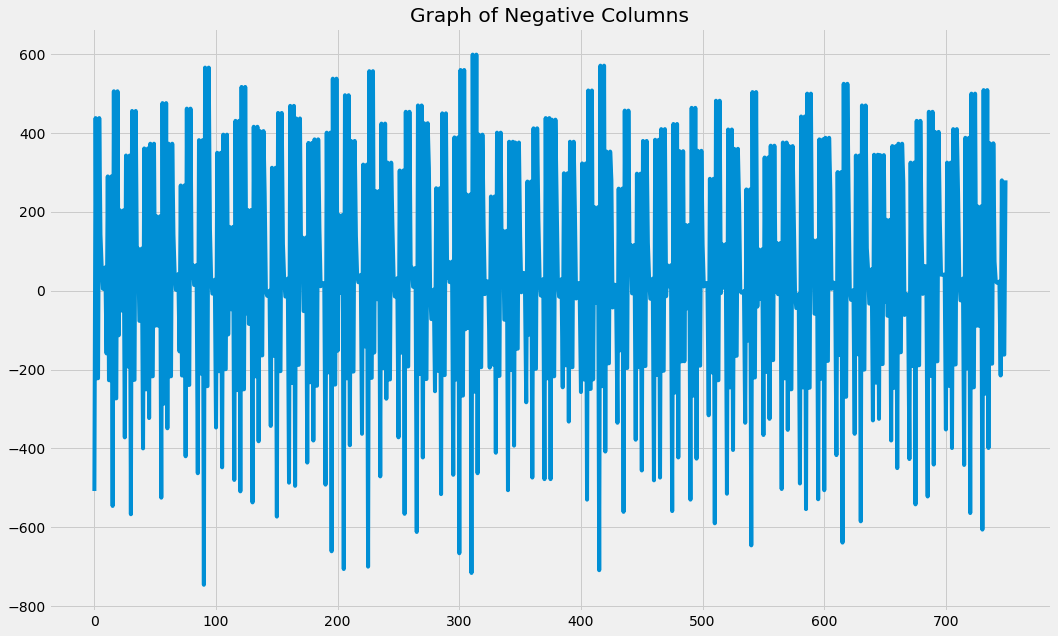

'As we can noticed the most of the Negative Signals are from less than 600 to and greater than -600'

In [10]:
#Plotting Negative DataFrame
plt.figure(figsize=(16, 10))
plt.plot(range(len(sample_neg)), sample_neg)
plt.title("Graph of Negative Columns")
plt.show()
'''As we can noticed the most of the Negative Signals are from less than 600 to and greater than -600'''

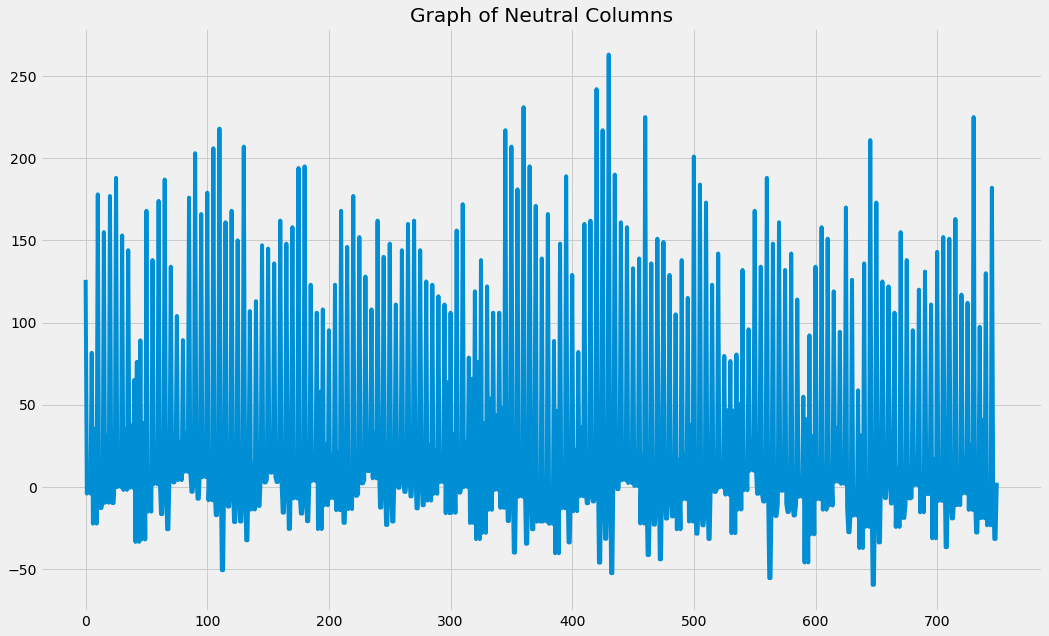

'As we can see the most of the Neutral Signals ae in between -50 to 250 '

In [11]:
#Plotting Neutral DataFrame
plt.figure(figsize=(16, 10))
plt.plot(range(len(sample_neu)), sample_neu)
plt.title("Graph of Neutral Columns")
plt.show()
'''As we can see the most of the Neutral Signals ae in between -50 to 250 '''

In [12]:
def Transform_data(data):
    #Encoding Lables into numbers
    encoding_data = ({'NEUTRAL': 0, 'POSITIVE': 1, 'NEGATIVE': 2} )
    data_encoded = data.replace(encoding_data)
    #getting brain signals into x variable
    x=data_encoded.drop(["label"]  ,axis=1)
    #getting labels into y variable
    y = data_encoded.loc[:,'label'].values
    scaler = StandardScaler()
    #scaling Brain Signals
    scaler.fit(x)
    X = scaler.transform(x)
    #One hot encoding Labels 
    Y = to_categorical(y)
    return X,Y



In [13]:
#Calling above function and splitting dataset into train and test
X,Y = Transform_data(data)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 8)


In [14]:
#checking shape of dataset
x_train.shape[1]

2548

In [15]:
def create_model():
    #input layer of model for brain signals
    inputs = tf.keras.Input(shape=(x_train.shape[1],))
    #Hidden Layer for Brain signal using LSTM(GRU)
    expand_dims = tf.expand_dims(inputs, axis=2)

    gru = tf.keras.layers.GRU(256, return_sequences=True)(expand_dims)
    #Flatten Gru layer into vector form (one Dimensional array)
    flatten = tf.keras.layers.Flatten()(gru)
    #output latyer of Model
    outputs = tf.keras.layers.Dense(3, activation='softmax')(flatten)


    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    print(model.summary())
    return model

In [16]:
#cretaing model
lstmmodel = create_model()
#Compiling model 
lstmmodel.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2548)]            0         
_________________________________________________________________
tf.expand_dims (TFOpLambda)  (None, 2548, 1)           0         
_________________________________________________________________
gru (GRU)                    (None, 2548, 256)         198912    
_________________________________________________________________
flatten (Flatten)            (None, 652288)            0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1956867   
Total params: 2,155,779
Trainable params: 2,155,779
Non-trainable params: 0
_________________________________________________________________
None


In [17]:


#Training and Evaluting model
history = lstmmodel.fit(x_train, y_train, epochs = 10, validation_split=0.1)
loss, acc = lstmmodel.evaluate(x_test, y_test)



Epoch 1/10
48/48 [==============================] - 11s 147ms/step - loss: 0.6480 - accuracy: 0.8566 - val_loss: 0.2409 - val_accuracy: 0.9240
Epoch 2/10
48/48 [==============================] - 7s 140ms/step - loss: 0.2209 - accuracy: 0.9302 - val_loss: 0.2735 - val_accuracy: 0.8889
Epoch 3/10
48/48 [==============================] - 7s 140ms/step - loss: 0.1037 - accuracy: 0.9583 - val_loss: 0.1673 - val_accuracy: 0.9415
Epoch 4/10
48/48 [==============================] - 7s 140ms/step - loss: 0.0757 - accuracy: 0.9772 - val_loss: 0.1994 - val_accuracy: 0.9474
Epoch 5/10
48/48 [==============================] - 7s 140ms/step - loss: 0.0552 - accuracy: 0.9752 - val_loss: 0.1632 - val_accuracy: 0.9474
Epoch 6/10
48/48 [==============================] - 7s 140ms/step - loss: 0.0469 - accuracy: 0.9831 - val_loss: 0.2611 - val_accuracy: 0.9181
Epoch 7/10
48/48 [==============================] - 7s 140ms/step - loss: 0.0577 - accuracy: 0.9817 - val_loss: 0.2750 - val_accuracy: 0.9298
Epoch

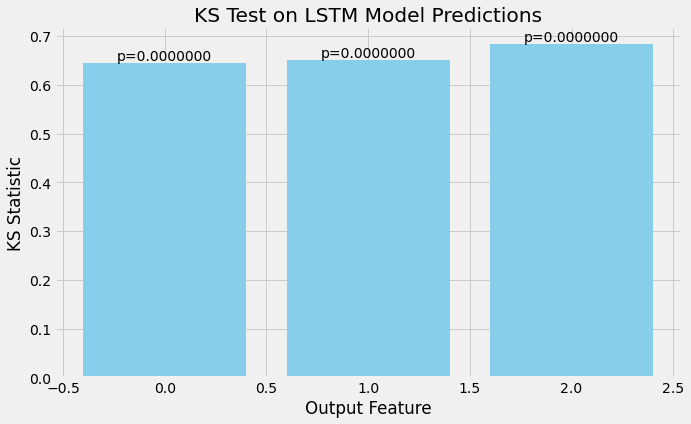

([0.6440281030444965, 0.6510538641686182, 0.6838407494145199],
 [1.0808727526209138e-83, 1.0665206338919832e-85, 1.7380088210439284e-95])

In [23]:
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt

def ks_test_lstm(model, X_test, y_test):
    """
    Performs the Kolmogorov-Smirnov test on the predictions from an LSTM model.

    Args:
    model: A trained LSTM model.
    X_test: Test set features.
    y_test: Actual target values for the test set.
    """
    # Generate predictions
    predictions = model.predict(x_test)

    # Perform KS test on each output feature
    ks_stats = []
    p_values = []
    for i in range(y_test.shape[1]):  # Assuming y_test is a 2D array with multiple columns
        ks_stat, p_value = ks_2samp(y_test[:, i], predictions[:, i])
        ks_stats.append(ks_stat)
        p_values.append(p_value)
    
    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(ks_stats)), ks_stats, color='skyblue')
    plt.xlabel('Output Feature')
    plt.ylabel('KS Statistic')
    plt.title('KS Test on LSTM Model Predictions')
    for i, p in enumerate(p_values):
        plt.text(i, ks_stats[i], f'p={p:.7f}', ha='center', va='bottom')
    plt.show()
    
    return ks_stats, p_values

# Usage

ks_test_lstm(lstmmodel, x_test, y_test)


In [ ]:
#Loss and Accuracy of model on Testiong Dataset 
print(f"Loss on testing: {loss*100}",f"\nAccuracy on Training: {acc*100}")

In [ ]:
#predicting model on test set for plotting Confusion Matrix
pred  = lstmmodel.predict(x_test)

In [ ]:
import matplotlib.pyplot as plt
from scipy import stats

def plot_ks_test(y_true, y_pred):

    D, p = stats.ks_2samp(y_true, y_pred)
    
    # Generate x-axis for plot 
    x = np.linspace(-1, 1, 500)

    # Use constant value of statistic  
    y = D*np.ones(500) 
    
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(x, y, 'r-', lw=2,  
            label='KS Test statistic')

    ax.plot([-D, D], [0, 0], 'k--', lw=2)
    ax.plot([0, 0], [0, 1], 'k--', lw=2)

    ax.text(-0.5, 0.3, 'D = %.3f\np = %.3f' % (D, p), fontdict={'size':10})
    
    ax.legend(loc='lower right')
    ax.set_title('Kolmogorov-Smirnov Test Results');

# Call after model predictions
y_test1 = np.argmax(y_test,axis=1)
pred1 = np.argmax(pred,axis=1)
print(len(y_test1), len(pred1))
plot_ks_test(y_test1, pred1)

In [ ]:
#Creation of Function of Confusion Matrix
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(data.label.unique()))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
#after getting prediction checking maximum score prediction to claim which emotion this brain signal belongs to
pred1 = np.argmax(pred,axis=1)

In [ ]:
#inversing the one hot encoding
y_test1 =   np.argmax(y_test,axis=1)

In [ ]:
#printing first 10 Actual and predicted outputs of Test brain signals 
print("Predicted:  ",pred1[:10])
print("\n")
print("Actual: ",y_test1[:10])


In [ ]:
#Plotting Confusion matrix of Lstm Model
cm = confusion_matrix(y_test1, pred1)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.rcParams["figure.figsize"]=(20,5)
plt.figure()
plot_confusion_matrix(cm,["Neutral","Positive","Negative"])

In [ ]:
names1 = ["Neutral","Positive","Negative"]

In [ ]:
#Training our dataset on different Classifiers to check the results and creating their classification reports
#NAves Bayes Clssifier
Classifier_gnb = GaussianNB().fit(x_train, np.argmax(y_train,axis=1))
pred_gnb = Classifier_gnb.predict(x_test)
print ('\n*\t\tClassification Report GNB:\n', classification_report(np.argmax(y_test,axis=1), pred_gnb))
confusion_matrix_graph = confusion_matrix(np.argmax(y_test,axis=1), pred_gnb)
### Support Vector Machine

Classifier_svm = svm.SVC(kernel='linear').fit(x_train, np.argmax(y_train,axis=1))
pred_svm = Classifier_svm.predict(x_test)
print ('\n*\t\tClassification Report SVM:\n', classification_report(np.argmax(y_test,axis=1), pred_svm))
confusion_matrix_graph = confusion_matrix(np.argmax(y_test,axis=1), pred_svm)
### Logistic Regression

Classifier_LR = linear_model.LogisticRegression(solver = 'liblinear', C = 75).fit(x_train, np.argmax(y_train,axis=1))
pred_LR = Classifier_LR.predict(x_test)
print ('\n*\t\tClassification Report LR:\n', classification_report(np.argmax(y_test,axis=1), pred_LR))
confusion_matrix_graph = confusion_matrix(np.argmax(y_test,axis=1), pred_LR)
### Decision Tree Regressor

Classifier_dt = tree.DecisionTreeClassifier().fit(x_train, np.argmax(y_train,axis=1))
pred_dt = Classifier_dt.predict(x_test)
print ('\n*\t\tClassification Report Deccsion Tree:\n', classification_report(np.argmax(y_test,axis=1), pred_dt))
confusion_matrix_graph = confusion_matrix(np.argmax(y_test,axis=1), pred_dt)
### Random Forest

Classifier_forest = RandomForestClassifier(n_estimators = 50, random_state = 0).fit(x_train,np.argmax(y_train,axis=1))
pred_fr = Classifier_dt.predict(x_test)


print ('\n*\t\tClassification Report Random Forest:\n', classification_report(np.argmax(y_test,axis=1), pred_fr))
confusion_matrix_graph = confusion_matrix(np.argmax(y_test,axis=1), pred_fr)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
classifiers = [GaussianNB(),svm.SVC(kernel='linear'),
               linear_model.LogisticRegression(solver = 'liblinear', C = 75),
               RandomForestClassifier(n_estimators = 50, random_state = 0)]
from sklearn.metrics import plot_confusion_matrix
for cls in classifiers:
    cls.fit(x_train,np.argmax(y_train,axis=1))
    
colors = [ 'YlOrBr', 'GnBu', 'BuPu', 'PuRd']
for cls, ax,c in zip(classifiers, axes.flatten(),colors):
    plot_confusion_matrix(cls, 
                          x_test, 
                          np.argmax(y_test,axis=1), 
                          ax=ax, 
                          cmap=c,
                         display_labels= names1)
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()


In [ ]:
#Classification Report of Lstm model
print('\n*\t\tClassification Report OF Brain Waves LSTM:\n', classification_report(np.argmax(y_test,axis=1), np.argmax(lstmmodel.predict(x_test),axis=1) ))

In [ ]:
#Plotting Graph of Lstm model Training, Loss and Accuracy
plt.style.use("fivethirtyeight")
plt.figure(figsize = (20,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss",fontsize=20)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train loss', 'validation loss'], loc ='best')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy",fontsize=20)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['training accuracy', 'validation accuracy'], loc ='best')
plt.show()